# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import time
import random
import numpy    as np
import pandas   as pd


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt
import seaborn           as sns

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# tsmoothie library
#
from tsmoothie.smoother   import *
from tsmoothie.bootstrap  import BootstrappingWrapper
from tsmoothie.utils_func import create_windows
from tsmoothie.utils_func import sim_seasonal_data
from tsmoothie.utils_func import sim_randomwalk


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow                  as tf
from   tensorflow.keras            import backend as K
from   tensorflow.keras.models     import *
from   tensorflow.keras.layers     import *
from   tensorflow.keras.callbacks  import *
from   tensorflow.keras.optimizers import *

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Keras Hypetune library
#
from kerashypetune import KerasGridSearch


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics     import *

# Import data

In [3]:
# Start timer
#
start = time.time()


# Load dataset
#
df = pd.read_csv('Data/data.csv')
print('[INFO] Dataset loaded')


# Stop timer
#
print('[INFO] Time %.2f' % (time.time() - start))


df.head()

[INFO] Dataset loaded
[INFO] Time 0.01


,Date,X_1,X_2,X_3,Y
0,2021-01-01 00:00:00,7.056209,-2.394616,1.411172,6.072766
1,2021-01-01 01:00:00,4.188819,-4.089676,2.196976,2.296119
2,2021-01-01 02:00:00,8.914952,3.813954,2.139506,14.868412
3,2021-01-01 03:00:00,16.034641,2.544816,1.748289,20.327746
4,2021-01-01 04:00:00,16.130486,-5.583731,2.689207,13.235962


## Preprocess

In [4]:
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

## Smooth data - Example

In [5]:
# Smooth training data
#
smoother = SpectralSmoother(smooth_fraction=0.18, pad_len=12);
smoother.smooth(df.T);

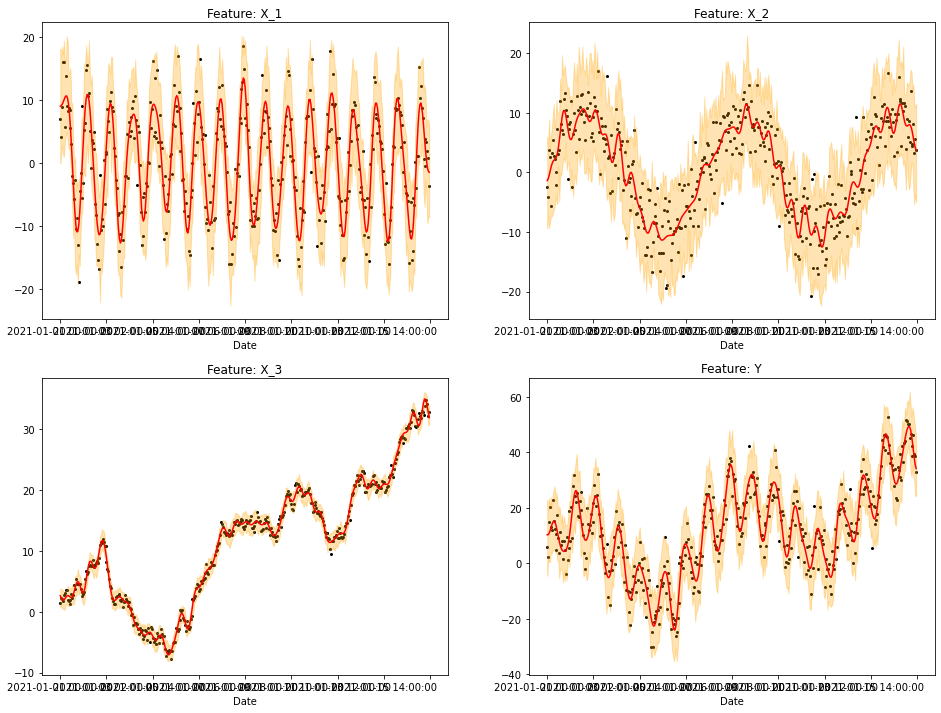

In [6]:
# Bootstrap training data (only for visualization)
#
plt.figure(figsize=(16,12))

for i, feature in enumerate(df.columns):
    
    plt.subplot(2, 2, i+1)
    
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                               bootstrap_type = 'mbb', 
                               block_length   = 24)
    
    bts_samples = bts.sample(df[feature], n_samples = 30)
    
    # Plot series
    #
    pd.Series(smoother.smooth_data[i], index=df.index).plot(color='red')


    # Plot bootstraps
    #
    plt.scatter(df.index, smoother.data[i], color='black', s=4)
    #
    plt.fill_between(df.index, bts_samples.min(0), bts_samples.max(0), alpha=0.3, color='orange')

    
    plt.title('Feature: {}'.format(feature))

# Parameters



In [7]:
# Parameters
#
Lag     = 24
Horizon = 6

cols    = df.columns

# Training/Testing

In [8]:
idx = int( df.shape[0] * 0.7 )

df_train = df[:idx]
df_test  = df[idx:]

print('[INFO] Training shape: ', df_train.shape)
print('[INFO] Testing shape: ', df_test.shape)

[INFO] Training shape:  (280, 4)
[INFO] Testing shape:  (120, 4)


## Training data (including bootstrap series)

In [9]:
bts_samples = []

for i, feature in enumerate(cols):
    
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                               bootstrap_type = 'mbb', 
                               block_length   = 24)
    
    bts_samples.append(bts.sample(df_train[feature], n_samples=30))
    
bts_samples = np.stack(bts_samples, axis=-1)

print('[INFO] Bootstrapped series created')
print('[INFO] Number of Bootstrapped series for each feature: ', bts_samples.shape[0])

[INFO] Bootstrapped series created
[INFO] Number of Bootstrapped series for each feature:  30


In [10]:
### CREATE TRAIN/VALIDATION WINDOWS W/ BOOTSTRAP ###

trainX = [create_windows(df_train[cols], window_shape=Lag,     end_id=-Horizon)]
trainY = [create_windows(df_train[cols], window_shape=Horizon, start_id=Lag)   ]


for i in range(bts_samples.shape[0]):

    _X = create_windows(bts_samples[i], window_shape=Lag,     end_id=-Horizon)
    _y = create_windows(bts_samples[i], window_shape=Horizon, start_id=Lag)
    
    trainX.append(_X)
    trainY.append(_y)
    
trainX = np.concatenate(trainX); 
trainY = np.concatenate(trainY); 


trainY = np.squeeze(trainY[...,[-1]], -1)

## Testing data

In [12]:
### CREATE TEST WINDOWS AND STANDARDIZE ###

testX = create_windows(df_test[cols], window_shape=Lag,     end_id   = -Horizon)
testY = create_windows(df_test[cols], window_shape=Horizon, start_id = Lag)

testY = np.squeeze(testY[...,[-1]], -1)

## Scaling

In [13]:
# Setup scaler
#
scaler = StandardScaler()

trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
testX  = scaler.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)

# Forecasting Model

In [14]:
def CreateModel( param ):
   
    model = Sequential()
    model.add(LSTM(param['unit'], activation=param['act']))
    model.add(RepeatVector(param['Horizon']))
    model.add(LSTM(param['unit'], activation=param['act'], return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    opt_choices = {'adam': Adam(),
                   'rms': RMSprop()}
    
    opt = opt_choices[ param['opt'] ]
    opt.lr = param['lr'] 
    
    model.compile(opt, 'mse')
    
    return model

## Model parameters

In [15]:
### CREATE GRID FOR HYPERPARAM SEARCH ###

param_grid = {
    'unit':       [64, 128], 
    'lr':         [1e-2, 1e-3], 
    'act':        ['elu', 'relu', 'tanh'], 
    'opt':        ['adam'],
    'epochs':     200,
    'batch_size': 512,
    'Horizon':    Horizon
}

## Training & Hyperparameter optimization

In [16]:
# Earlystopping
#
earlystopping = EarlyStopping(patience             = 20, 
                              verbose              = 1, 
                              min_delta            = 0.001, 
                              monitor              = 'val_loss', 
                              mode                 = 'auto', 
                              restore_best_weights = True)


# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                    factor      = 0.5,
                                    patience    = 10)

In [17]:
# Start clock
start = time.time()

hypermodel = CreateModel

kgs = KerasGridSearch(hypermodel        = hypermodel, 
                      param_grid        = param_grid, 
                      monitor           = 'val_loss', 
                      greater_is_better = False, 
                      tuner_verbose     = 1)

kgs.search(trainX, trainY, 
           callbacks        = [earlystopping, lrs_scheduler],
           validation_split = 0.1)
#          validation_data = (validX, validY))           



# Terminate clock
print('[INFO] Time %.2f' % (time.time() - start))


12 trials detected for ('unit', 'lr', 'act', 'opt', 'epochs', 'batch_size', 'Horizon')

***** (1/12) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512, 'Horizon': 6})
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
SCORE: 23.68623 at epoch 86

***** (2/12) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'tanh', 'opt': 'adam', 'epochs': 200, 'batch_size': 512, 'Horizon': 6})
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
SCORE: 23.15334 at epoch 74

***** (3/12) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512, 'Horizon': 6})
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
SCORE: 23.56739 at epoch 87

***** (4/12) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512, 'Horizon': 6})
Restoring model weights from the end of the best epoc

In [19]:
print('[INFO] Best score: ', kgs.best_score)



print('[INFO] Optimized hyperparameters\n')
for (parameter, value) in kgs.best_params.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.3f' % (parameter,value))
    else:
        print(' >%25s: %s' % (parameter,value))

[INFO] Best score:  22.79494
[INFO] Optimized hyperparameters

 >                     unit: 128
 >                       lr: 0.001
 >                      act: tanh
 >                      opt: adam
 >                   epochs: 174
 >               batch_size: 512
 >                  Horizon: 6
 >          steps_per_epoch: 14


# Evaluation

In [21]:
# Calcuate predictions
#
pred = kgs.best_model.predict( testX ).squeeze(-1)

## Visualize prediction for each value of Forecasting Horizon

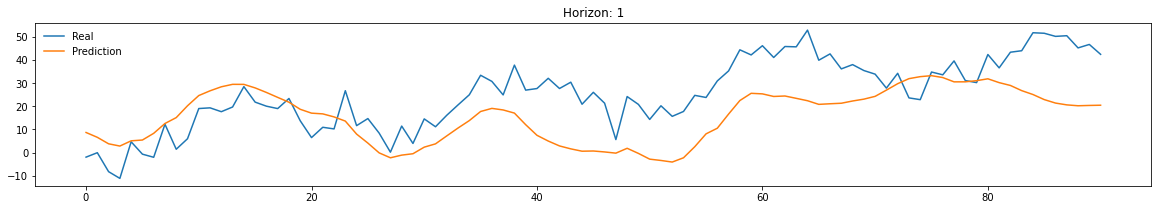

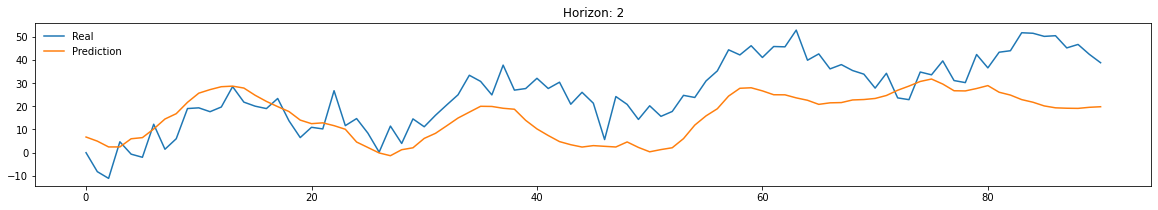

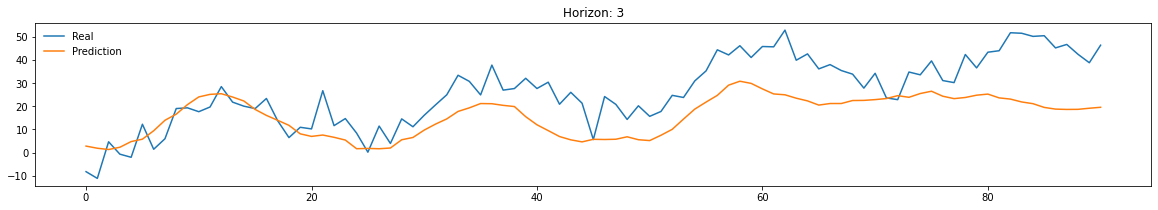

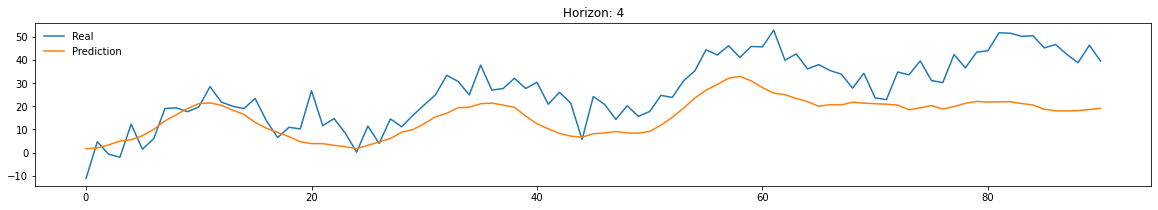

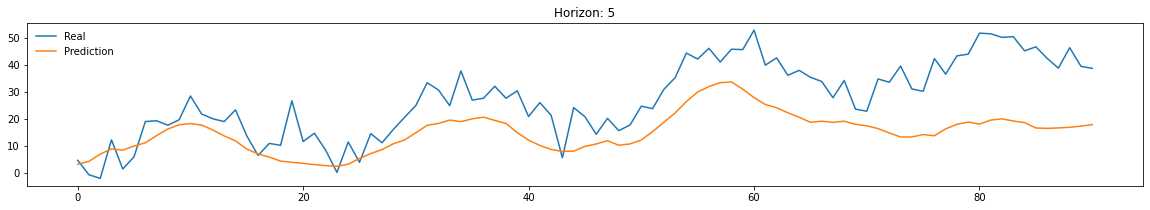

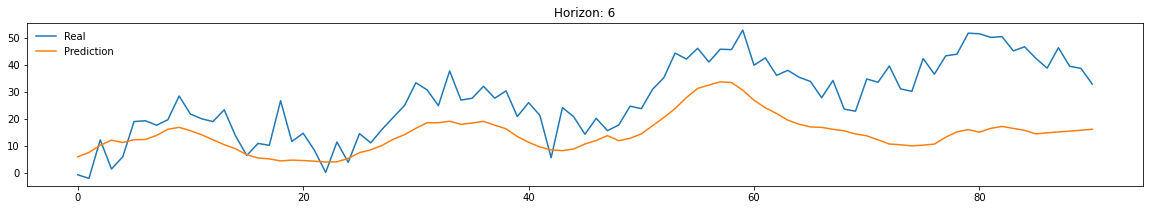

In [22]:
for t_h in range( Horizon ):
    
    plt.figure( figsize=(20, 3) )

    plt.plot( testY[:,t_h] )
    plt.plot( pred[:,t_h] )
    
    plt.legend(['Real', 'Prediction'], frameon=False)
    plt.title('Horizon: {}'.format(t_h+1))

## Visualize prediction

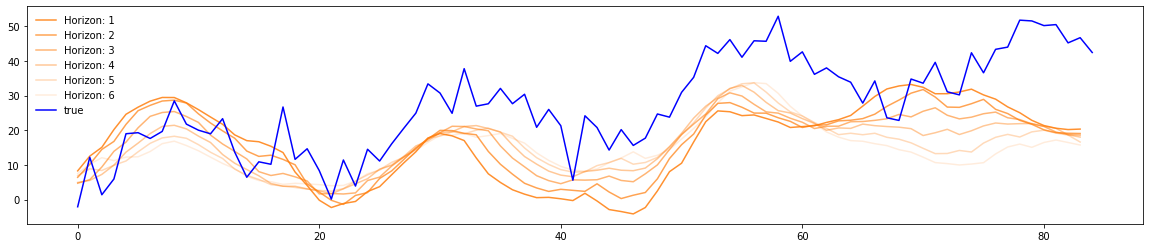

In [23]:
### PLOT PREDICTIONS ON TEST ###

plt.figure(figsize=(20, 4))

for t_h in range(Horizon):
    plt.plot(pred[(Horizon-t_h):-(t_h+1),t_h], color = 'tab:orange', alpha = 1-1/(Horizon+1)*(t_h+1), label='Horizon: {}'.format(t_h+1))

plt.plot(testY[Horizon:,0], 
         c='blue', label='true')

plt.legend(frameon=False); 
plt.show();

## Compare Forecasting model with Traditional model

In [24]:
Performance_Foresting_Model = {'Horizon': [], 'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}
Performance_Naive_Model     = {'Horizon': [], 'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}


for i in range( Horizon ):
        
    # Store results (Performance metrics)
    #
    Performance_Foresting_Model['Horizon'] += [i+1]
    Performance_Foresting_Model['RMSE']    += [ rmse(testY[:,i], pred[:,i]) ]
    Performance_Foresting_Model['MAE']     += [ mae(testY[:,i], pred[:,i]) ]
    Performance_Foresting_Model['SMAPE']   += [ smape(testY[:,i], pred[:,i]) ]
    Performance_Foresting_Model['R2']      += [ R2(testY[:,i], pred[:,i]) ]
    
    # Store results (Performance metrics)
    #
    Performance_Naive_Model['Horizon'] += [i+1]
    Performance_Naive_Model['RMSE']    += [ rmse(testY[1:,i], testY[:-1,0]) ]
    Performance_Naive_Model['MAE']     += [ mae(testY[1:,i], testY[:-1,0]) ]
    Performance_Naive_Model['SMAPE']   += [ smape(testY[1:,i], testY[:-1,0]) ]
    Performance_Naive_Model['R2']      += [ R2(testY[1:,i], testY[:-1,0]) ]
    
    
Performance_Foresting_Model = pd.DataFrame( Performance_Foresting_Model )
Performance_Foresting_Model.set_index('Horizon', inplace=True)

Performance_Naive_Model = pd.DataFrame( Performance_Naive_Model )
Performance_Naive_Model.set_index('Horizon', inplace=True)

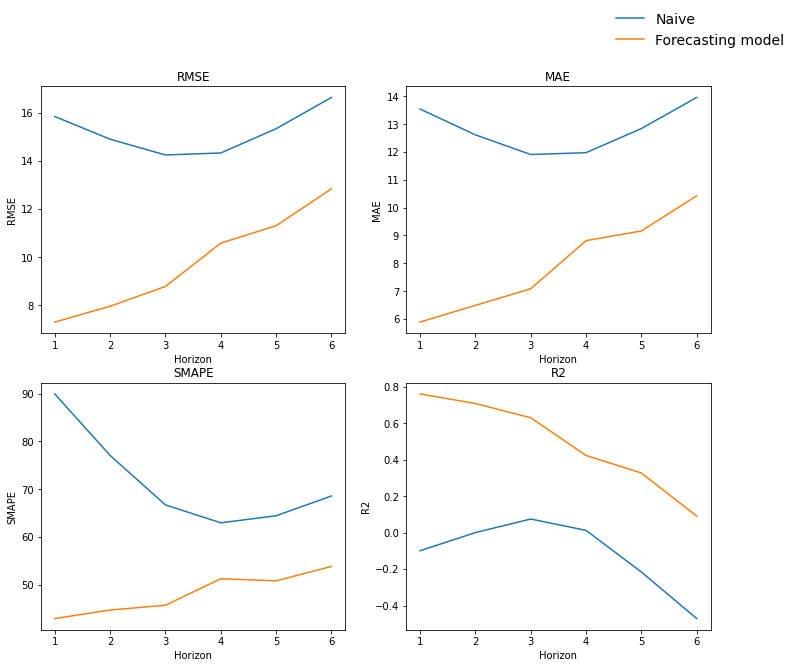

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 10))

Performance_Foresting_Model['RMSE'].plot(ax=ax[0][0])
Performance_Foresting_Model['MAE'].plot(ax=ax[0][1])
Performance_Foresting_Model['SMAPE'].plot(ax=ax[1][0])
Performance_Foresting_Model['R2'].plot(ax=ax[1][1])

Performance_Naive_Model['RMSE'].plot(ax=ax[0][0], color='tab:orange')
Performance_Naive_Model['MAE'].plot(ax=ax[0][1], color='tab:orange')
Performance_Naive_Model['SMAPE'].plot(ax=ax[1][0], color='tab:orange')
Performance_Naive_Model['R2'].plot(ax=ax[1][1], color='tab:orange')

ax[0][0].set_ylabel('RMSE');
ax[0][1].set_ylabel('MAE');
ax[1][0].set_ylabel('SMAPE');
ax[1][1].set_ylabel('R2');


ax[0][0].set_title('RMSE');
ax[0][1].set_title('MAE');
ax[1][0].set_title('SMAPE');
ax[1][1].set_title('R2');

fig.legend(['Naive', 'Forecasting model'], fontsize=14, frameon=False)